# **Measuring Efficacy in clustering**


This notebook is a tutorial on auditing efficacy within a clustering task. We will use the _holisticai_ library throughout.

The sections are organised as follows :

1. Load the data : we load the adult dataset as a pandas DataFrame
2. Pre-Processing and Train a Model : we train a kmeans model (sklearn)
3. Measure efficacy : we compute a few efficacy metrics.

## **1. Load the data**

In [11]:
# Imports
import numpy as np
import pandas as pd

#sys
import sys
sys.path.append('../../')

We will start by importing the adult dataset, which we host on our library. The adult dataset contains a set of informations extract from US 1994 Census database. It includes personal information about the individuals, specifically sex, race, and education. In this tutorial we will perform unsupervised learning to cluster the data, then measure whether this clustering contains gender or race information (clustering bias).

In [12]:
# Get data
from holisticai.datasets import load_adult
df = load_adult()['frame']
df.head()

c:\Users\Cristian\anaconda3\envs\metrics\lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K
3,44.0,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K
4,18.0,NaN,103497.0,Some-college,10.0,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K


## **2. Preprocess data and Train a model**

In [13]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Dataset
dataset = load_adult()

# Dataframe
df = pd.concat([dataset["data"], dataset["target"]], axis=1)
protected_variables = ["sex", "race"]
output_variable = ["class"]

# Simple preprocessing
y = df[output_variable].replace({">50K": 1, "<=50K": 0})
X = pd.get_dummies(df.drop(protected_variables + output_variable, axis=1))
group = ["sex"]
group_a = df[group] == "Female"
group_b = df[group] == "Male"
data = [X, y, group_a, group_b]

# Train test split
dataset = train_test_split(*data, test_size=0.2, shuffle=True)
train_data = dataset[::2]
test_data = dataset[1::2]

c:\Users\Cristian\anaconda3\envs\metrics\lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [14]:
from sklearn.cluster import KMeans

ks = range(1, 8)
inertias = []
X_train, _, group_a_train, group_b_train = train_data

for k in ks:
    # create a KMeans instance with k clusters: model
    model = KMeans(n_clusters = k)
    
    # fit model to samples
    model.fit(X_train)
    
    # append the inertia to the list of inertias
    inertias.append(model.inertia_)

c:\Users\Cristian\anaconda3\envs\metrics\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Cristian\anaconda3\envs\metrics\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Cristian\anaconda3\envs\metrics\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Cristian\anaconda3\envs\metrics\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

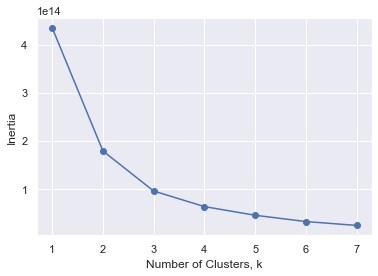

In [15]:
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of Clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.show()

In [16]:
# we choose to use 4 clusters
model = KMeans(n_clusters = 4)
model.fit(X_train)

# test data
X, _, group_a, group_b = test_data

# predict
y_pred = model.predict(X)

c:\Users\Cristian\anaconda3\envs\metrics\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## **3. Measure Efficacy**

In [17]:
from holisticai.efficacy.metrics import clustering_efficacy_metrics
clustering_efficacy_metrics(X, y_pred)

,Value,Reference
Metric,,
Silhouette,0.559491,1.0
Calinski Harabasz,18388.902701,inf
Davies Bouldin,0.582753,0.0
